### Predicting Football Results Using Bayesian Modelling with Python and PyMC3
https://pena.lt/y/2021/08/25/predicting-football-results-using-bayesian-statistics-with-python-and-pymc3/

In [60]:
import pandas as pd
import numpy as np
import penaltyblog as pb

In [61]:
data_file = './data/lmf-ac-2021-22.csv'
df = pd.read_csv(data_file, index_col=0)
df.head()

,AMÉ,ATL,ASL,CAZ,GUA,JUÁ,LEÓ,MAZ,MON,NEC,PAC,PUE,QUE,SAN,TIJ,TOL,UNL,UNM
Home \ Away,,,,,,,,,,,,,,,,,,
América,—,0–2,2–3,0–0,0–0,3–0,2–0,2–0,0–0,2–1,1–3,2–0,1–1,2–1,2–0,3–0,1–0,2–0
Atlas,0–1,—,1–0,0–0,1–1,2–0,2–0,1–2,2–1,2–1,0–1,0–1,2–0,2–1,0–2,0–0,1–1,0–0
Atlético San Luis,0–1,2–6,—,0–0,2–2,0–1,2–0,1–0,1–1,0–2,0–2,2–1,1–1,1–3,4–1,0–1,0–3,2–0
Cruz Azul,2–1,1–0,0–1,—,0–1,1–0,0–1,0–2,1–1,1–2,1–1,1–3,2–0,1–2,2–0,4–0,1–1,2–1
Guadalajara,0–0,0–1,1–2,1–1,—,2–2,0–3,3–0,1–3,2–1,1–0,2–3,1–1,1–0,2–1,2–0,1–3,3–1


In [41]:
df.index = df.columns
rows = []
for i in df.index:
    for c in df.columns:
        if i == c: continue
        score = df.loc[i, c]
        if score == '—': continue
        ssplit = score.split('–')
        #print(ssplit[1])
        rows.append([i, c, ssplit[0], ssplit[1]])
df = pd.DataFrame(rows, columns = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'])
df.head()

,HomeTeam,AwayTeam,FTHG,FTAG
0,AMÉ,ATL,0,2
1,AMÉ,ASL,2,3
2,AMÉ,CAZ,0,0
3,AMÉ,GUA,0,0
4,AMÉ,JUÁ,3,0


In [53]:
df.dtypes

HomeTeam    object
AwayTeam    object
FTHG         int64
FTAG        object
dtype: object

In [54]:
df['FTHG']= df['FTHG'].astype(int)
df['FTAG']= df['FTAG'].astype(int)

In [55]:
def rho_correction(goals_home, goals_away, home_exp, away_exp, rho):
    if goals_home == 0 and goals_away == 0:
        return 1 - (home_exp * away_exp * rho)
    elif goals_home == 0 and goals_away == 1:
        return 1 + (home_exp * rho)
    elif goals_home == 1 and goals_away == 0:
        return 1 + (away_exp * rho)
    elif goals_home == 1 and goals_away == 1:
        return 1 - rho
    else:
        return 1.0

In [56]:
def log_likelihood(
    goals_home_observed,
    goals_away_observed,
    home_attack,
    home_defence,
    away_attack,
    away_defence,
    home_advantage,
    rho,
):
    goal_expectation_home = np.exp(home_attack + away_defence + home_advantage)
    goal_expectation_away = np.exp(away_attack + home_defence)

    home_llk = poisson.pmf(goals_home_observed, goal_expectation_home)
    away_llk = poisson.pmf(goals_away_observed, goal_expectation_away)
    adj_llk = rho_correction(
        goals_home_observed,
        goals_away_observed,
        goal_expectation_home,
        goal_expectation_away,
        rho,
    )

    if goal_expectation_home < 0 or goal_expectation_away < 0 or adj_llk < 0:
        return 10000

    log_llk = np.log(home_llk) + np.log(away_llk) + np.log(adj_llk)

    return -log_llk

In [58]:
from pprint import pprint
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson


def fit_poisson_model():
    teams = np.sort(np.unique(np.concatenate([df["HomeTeam"], df["AwayTeam"]])))
    n_teams = len(teams)

    params = np.concatenate(
        (
            np.random.uniform(0.5, 1.5, (n_teams)),  # attack strength
            np.random.uniform(0, -1, (n_teams)),  # defence strength
            [0.25],  # home advantage
            [-0.1], # rho
        )
    )

    def _fit(params, df, teams):
        attack_params = dict(zip(teams, params[:n_teams]))
        defence_params = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        home_advantage = params[-2]
        rho = params[-1]

        llk = list()
        for idx, row in df.iterrows():
            tmp = log_likelihood(
                row["FTHG"],
                row["FTAG"],
                attack_params[row["HomeTeam"]],
                defence_params[row["HomeTeam"]],
                attack_params[row["AwayTeam"]],
                defence_params[row["AwayTeam"]],
                home_advantage,
                rho
            )
            llk.append(tmp)

        return np.sum(llk)

    options = {
        "maxiter": 100,
        "disp": False,
    }

    constraints = [{"type": "eq", "fun": lambda x: sum(x[:n_teams]) - n_teams}]

    res = minimize(
        _fit,
        params,
        args=(df, teams),
        constraints=constraints,
        options=options,
    )

    model_params = dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["home_adv", "rho"],
            res["x"],
        )
    )

    print("Log Likelihood: ", res["fun"])

    return model_params

In [59]:
model_params = fit_poisson_model()
pprint(model_params)

/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_13756/1988307049.py:27: RuntimeWarning: divide by zero encountered in log
  log_llk = np.log(home_llk) + np.log(away_llk) + np.log(adj_llk)


Log Likelihood:  816.7450935245429
{'attack_AMÉ': 1.1328636236836085,
 'attack_ASL': 1.017864987791107,
 'attack_ATL': 1.0405199344430616,
 'attack_CAZ': 1.0253767111904208,
 'attack_GUA': 0.9714788356889411,
 'attack_JUÁ': 0.5077717012964122,
 'attack_LEÓ': 0.9317486383350425,
 'attack_MAZ': 0.9750226072470171,
 'attack_MON': 1.004870551810199,
 'attack_NEC': 0.9274698925044227,
 'attack_PAC': 1.2172848726566463,
 'attack_PUE': 1.0220194765746493,
 'attack_QUE': 0.6911673653006161,
 'attack_SAN': 1.2024719691101098,
 'attack_TIJ': 0.7615563915538901,
 'attack_TOL': 1.1158977645978347,
 'attack_UNL': 1.3679213157409014,
 'attack_UNM': 1.0866933604751203,
 'defence_AMÉ': -1.3175362962558181,
 'defence_ASL': -0.8120646807016645,
 'defence_ATL': -1.3951301958605022,
 'defence_CAZ': -1.1053057779122133,
 'defence_GUA': -1.1028273999373457,
 'defence_JUÁ': -0.6928000742132148,
 'defence_LEÓ': -1.0585169690183778,
 'defence_MAZ': -0.7584595509667973,
 'defence_MON': -1.1186630388866607,
 'de

In [62]:
home_team = "LEÓ"
away_team = "ATL"

home_attack = model_params["attack_" + home_team]
home_defence = model_params["defence_" + home_team]
away_attack = model_params["attack_" + away_team]
away_defence = model_params["defence_" + away_team]
home_advantage = model_params["home_adv"]
rho = model_params["rho"]

home_goal_expectation = np.exp(home_attack + away_defence + home_advantage)
away_goal_expectation = np.exp(away_attack + home_defence)

home_probs = poisson.pmf([0, 1], home_goal_expectation)
away_probs = poisson.pmf([0, 1], away_goal_expectation)

probability_matrix_before = np.outer(home_probs, away_probs)

probability_matrix_after = probability_matrix_before.copy()
probability_matrix_after[0, 0] *= 1 - home_goal_expectation * away_goal_expectation * rho
probability_matrix_after[0, 1] *= 1 + home_goal_expectation * rho
probability_matrix_after[1, 0] *= 1 + away_goal_expectation * rho
probability_matrix_after[1, 1] *= 1 - rho

print(probability_matrix_after - probability_matrix_before)

[[ 0.01715357 -0.01715357]
 [-0.01715357  0.01715357]]


In [64]:
def dc_decay(xi, t):
    return np.exp(-xi * t)

Text(0, 0.5, 'Weight')

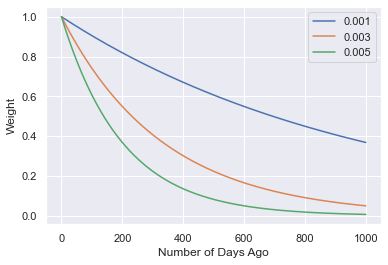

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

t = np.array(range(1000))
xis = [0.001, 0.003, 0.005]

for xi in xis:
    plt.plot(t, dc_decay(xi, t), label=str(xi))

plt.legend()
plt.xlabel("Number of Days Ago")
plt.ylabel("Weight")

In [4]:
df['result'] = np.where(df['yg1'].astype(int)-df['yg2'].astype(int) == 0, 'D', np.where(df['yg1'].astype(int)-df['yg1'].astype(int) >0, 'H', 'A'))

In [5]:
df

,home_team,away_team,yg1,yg2,result
0,AMÉ,ATL,0,2,A
1,AMÉ,ASL,2,3,A
2,AMÉ,CAZ,0,0,D
3,AMÉ,GUA,0,0,D
4,AMÉ,JUÁ,3,0,A
...,...,...,...,...,...
301,UNM,QUE,0,0,D
302,UNM,SAN,0,3,A
303,UNM,TIJ,3,1,A
304,UNM,TOL,5,0,A


In [6]:
fixtures = df

In [7]:
fixtures

,home_team,away_team,yg1,yg2,result
0,AMÉ,ATL,0,2,A
1,AMÉ,ASL,2,3,A
2,AMÉ,CAZ,0,0,D
3,AMÉ,GUA,0,0,D
4,AMÉ,JUÁ,3,0,A
...,...,...,...,...,...
301,UNM,QUE,0,0,D
302,UNM,SAN,0,3,A
303,UNM,TIJ,3,1,A
304,UNM,TOL,5,0,A


In [37]:
n_teams = len(fixtures["home_team"].unique())

teams = (
    fixtures[["home_team"]]
    .drop_duplicates()
    .sort_values("home_team")
    .reset_index(drop=True)
    .assign(team_index=np.arange(n_teams))
    .rename(columns={"home_team": "team"})
)

df = (
    fixtures.merge(teams, left_on="home_team", right_on="team")
    .rename(columns={"team_index": "hg"})
    .drop(["team"], axis=1)
    .merge(teams, left_on="away_team", right_on="team")
    .rename(columns={"team_index": "ag"})
    .drop(["team"], axis=1)
    #.sort_values("Date")
)

teams.iloc[0:20]

,team,team_index
0,AMÉ,0
1,ASL,1
2,ATL,2
3,CAZ,3
4,GUA,4
5,JUÁ,5
6,LEÓ,6
7,MAZ,7
8,MON,8
9,NEC,9


In [11]:
TEST_SIZE = 250
train = df.iloc[:-TEST_SIZE]
test = df.iloc[-TEST_SIZE:]

goals_home_obs = train["yg1"].astype(int).values
goals_away_obs = train["yg2"].astype(int).values
home_team = train["hg"].values
away_team = train["ag"].values

In [12]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    # home advantage
    home = pm.Flat("home")

    # attack ratings
    tau_att = pm.Gamma("tau_att", 0.1, 0.1)
    atts_star = pm.Normal("atts_star", mu=0, tau=tau_att, shape=n_teams)

    # defence ratings
    tau_def = pm.Gamma("tau_def", 0.1, 0.1)
    def_star = pm.Normal("def_star", mu=0, tau=tau_def, shape=n_teams)

    # apply sum zero constraints
    atts = pm.Deterministic("atts", atts_star - tt.mean(atts_star))
    defs = pm.Deterministic("defs", def_star - tt.mean(def_star))

    # calulate theta
    home_theta = tt.exp(home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(atts[away_team] + defs[home_team])

    # goal expectation
    home_points = pm.Poisson("home_goals", mu=home_theta, observed=goals_home_obs)
    away_points = pm.Poisson("away_goals", mu=away_theta, observed=goals_away_obs)


In [13]:
with model:
    trace = pm.sample(2000, tune=1000, cores=6, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [def_star, tau_def, atts_star, tau_att, home]


Sampling 6 chains for 1_000 tune and 2_000 draw iterations (6_000 + 12_000 draws total) took 78 seconds.
The number of effective samples is smaller than 25% for some parameters.


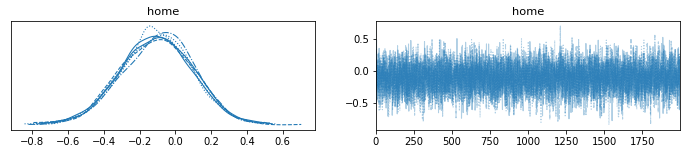

In [14]:
with model:
    pm.plot_trace(trace, var_names=["home"]);

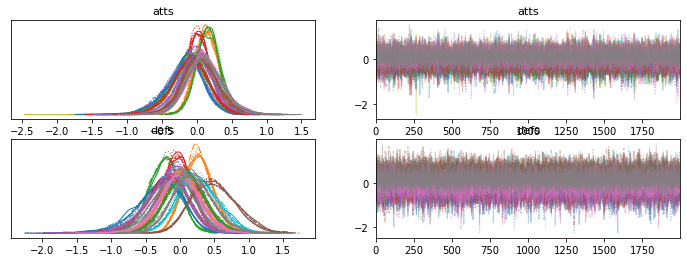

In [15]:
with model:
    pm.plot_trace(trace, var_names=["atts", "defs"]);

/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_13756/841394658.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])


<ErrorbarContainer object of 3 artists>

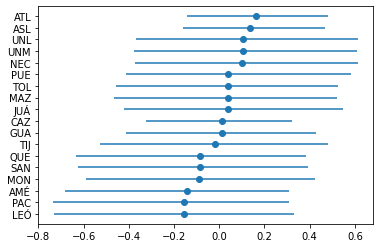

In [16]:
import arviz as az
import matplotlib.pyplot as plt

atts = (
    pd.DataFrame(az.stats.hdi(trace["atts"]), columns=["lower_hdi", "upper_hdi"])
    .assign(median=np.quantile(trace["atts"], 0.5, axis=0))
    .merge(teams, left_index=True, right_on="team_index")
    .drop(["team_index"], axis=1)
    .rename(columns={"team": "Team"})
    .assign(lower=lambda x: x["median"] - x["lower_hdi"])
    .assign(upper=lambda x: x["upper_hdi"] - x["median"])
    .sort_values("median", ascending=True)
)

plt.errorbar(
    atts["median"],
    atts["Team"],
    xerr=(atts[["lower", "upper"]].values).T,
    fmt="o",
)

/var/folders/4g/fy11b71x7jsd5j1s4bztn7gm0000gn/T/ipykernel_13756/3768474558.py:2: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])


<ErrorbarContainer object of 3 artists>

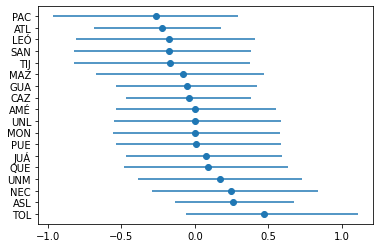

In [17]:
defs = (
    pd.DataFrame(az.stats.hdi(trace["defs"]), columns=["lower_hdi", "upper_hdi"])
    .assign(median=np.quantile(trace["defs"], 0.5, axis=0))
    .merge(teams, left_index=True, right_on="team_index")
    .drop(["team_index"], axis=1)
    .rename(columns={"team": "Team"})
    .assign(lower=lambda x: x["median"] - x["lower_hdi"])
    .assign(upper=lambda x: x["upper_hdi"] - x["median"])
    .sort_values("median", ascending=False)
)

plt.errorbar(
    defs["median"],
    defs["Team"],
    xerr=(defs[["lower", "upper"]].values).T,
    fmt="o",
)

In [18]:
def goal_expectation(trace, home_team_id, away_team_id):   
    # get parameters
    home = np.mean(trace["home"])
    atts_home = np.mean([x[home_team_id] for x in trace["atts"]])
    atts_away = np.mean([x[away_team_id] for x in trace["atts"]])
    defs_home = np.mean([x[home_team_id] for x in trace["defs"]])
    defs_away = np.mean([x[away_team_id] for x in trace["defs"]])

    # calculate theta
    home_theta = np.exp(home + atts_home + defs_away)
    away_theta = np.exp(atts_away + defs_home)

    # return the average per team
    return home_theta, away_theta

In [35]:
goal_expectation(trace, 16, 17)

(1.2126621047033148, 1.115536102227509)

In [36]:
goal_expectation(trace, 6, 2)

(0.5964726690549528, 0.9618838005978868)

In [21]:
from scipy.stats import poisson

def win_draw_loss(home_expectation, away_expectation, max_goals=10):
    h = poisson.pmf(range(max_goals+1), home_expectation)
    a = poisson.pmf(range(max_goals+1), away_expectation)    
    m = np.outer(h, a)

    home = np.sum(np.tril(m, -1))
    away = np.sum(np.triu(m, 1))
    draw = np.sum(np.diag(m))

    return home, draw, away   

In [22]:
def calculate_rps(df):
    rps = list()
    for idx, row in df.iterrows():
        if row["result"] == "H":
            outcome = 0
        elif row["result"] == "D":
            outcome = 1
        elif row["result"] == "A":
            outcome = 2

        h, a = goal_expectation(trace, row["hg"], row["ag"])
        predictions = win_draw_loss(h, a)

        rps.append(pb.metrics.rps(predictions, outcome))

    return np.mean(rps)

In [23]:
calculate_rps(test)

0.21893521411580644

In [24]:
def calculate_rps_dc(dc, df):
    rps = list()
    for idx, row in df.iterrows():
        if row["result"] == "H":
            outcome = 0
        elif row["result"] == "D":
            outcome = 1
        elif row["result"] == "A":
            outcome = 2

        predictions = dc.predict(row["home_team"], row["away_team"]).home_draw_away

        rps.append(pb.metrics.rps(predictions, outcome))

    return np.mean(rps)

#train["weight"] = pb.poisson.dixon_coles_weights(train["Date"],  0.001)

dc = pb.models.DixonColesGoalModel(
    train["yg1"],
    train["yg2"],
    train["home_team"],
    train["away_team"]
    #train["weight"]
)

dc.fit()

calculate_rps_dc(dc, test)


0.2702295090451032